In [1]:
# For reproducibility
import random
random.seed(493)

# For manipulating dataframes
import pandas as pd
import numpy as np

# To print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.shape

(731, 6)

In [4]:
duplicates = df[df.duplicated(subset=['client', 'year'], keep=False)]
duplicates.shape

(0, 6)

In [5]:
missing_counts = df.isna().sum()
missing_counts

client                      0
year                        0
sales                       0
revenue                     0
years_active                0
number_years_in_contract    0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

# Get unique client IDs
unique_clients = df['client'].unique()

# Split client IDs into train and test
train_clients, test_clients = train_test_split(
    unique_clients, test_size=0.2, random_state=493
)

# Create train/test sets by filtering on client
train_df = df[df['client'].isin(train_clients)].copy()
test_df = df[df['client'].isin(test_clients)].copy()

In [7]:
# Check missing values in train_df
print("Missing values in train_df:")
print(train_df.isna().sum())

# Check missing values in test_df
print("\nMissing values in test_df:")
print(test_df.isna().sum())

# Optionally, show number of rows with any missing values
print(f"\nRows with any missing values in train_df: {train_df.isna().any(axis=1).sum()}")
print(f"Rows with any missing values in test_df: {test_df.isna().any(axis=1).sum()}")

Missing values in train_df:
client                      0
year                        0
sales                       0
revenue                     0
years_active                0
number_years_in_contract    0
dtype: int64

Missing values in test_df:
client                      0
year                        0
sales                       0
revenue                     0
years_active                0
number_years_in_contract    0
dtype: int64

Rows with any missing values in train_df: 0
Rows with any missing values in test_df: 0


In [8]:
# Drop rows with missing values before modeling
train_df = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue'])

# Drop rows with missing values before modeling
test_df = test_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue'])

In [9]:
# Fit models using cleaned data
from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

# Prepare clean training data
train_df_clean = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue']).copy()

train_df_clean = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue']).copy()

# Reset index if already set
if train_df_clean.index.names == ['client', 'year']:
    train_df_clean = train_df_clean.reset_index()

# Now safely set the multi-index
train_df_clean = train_df_clean.set_index(['client', 'year'])

# Variables
exog_vars = ['sales', 'number_years_in_contract']
exog = sm.add_constant(train_df_clean[exog_vars])
endog = train_df_clean['revenue']

# Fit models
pooled_ols = PooledOLS(endog, exog).fit(cov_type='robust')
fe_model = PanelOLS(endog, train_df_clean[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='robust')
re_model = RandomEffects(endog, exog).fit(cov_type='robust')

# Compare model fit
fit_comparison = pd.DataFrame({
    'Model': ['Pooled OLS', 'Fixed Effects', 'Random Effects'],
    'R-squared': [
        pooled_ols.rsquared,
        getattr(fe_model.rsquared, 'within', fe_model.rsquared),  # fallback
        re_model.rsquared
    ],
    'Log-Likelihood': [pooled_ols.loglik, fe_model.loglik, re_model.loglik]
})

fit_comparison

C:\Users\Dd\AppData\Local\Temp\ipykernel_3004\205754374.py:24: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

number_years_in_contract

  fe_model = PanelOLS(endog, train_df_clean[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='robust')


,Model,R-squared,Log-Likelihood
0,Pooled OLS,0.850435,-8919.240740
1,Fixed Effects,0.882909,-8737.651200
2,Random Effects,0.851806,-8906.229128


In [10]:
# Rescale sales and revenue to make units manageable (divide by 1,000)
train_df['sales'] = train_df['sales'] / 1000
train_df['revenue'] = train_df['revenue'] / 1000
test_df['sales'] = test_df['sales'] / 1000
test_df['revenue'] = test_df['revenue'] / 1000

# Re-run fixed effects evaluation
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Clean and reindex training data
train_df_clean = train_df.dropna(subset=['sales', 'years_active', 'revenue']).copy()
if train_df_clean.index.names != ['client', 'year']:
    train_df_clean = train_df_clean.set_index(['client', 'year'])

# Fit Fixed Effects model
exog_vars = ['sales', 'years_active']
fe_model = PanelOLS(train_df_clean['revenue'], train_df_clean[exog_vars], entity_effects=True).fit()

# Extract coefficients
coeffs = fe_model.params

# Predict on test set
X_test = test_df[['sales', 'years_active']].copy()
y_test = test_df['revenue'].copy()
y_pred = np.dot(X_test, coeffs.values)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Test R-squared (structural only): {r2:.4f}")
print(f"Test RMSE (in thousands): {rmse:,.2f}")

Test R-squared (structural only): 0.5521
Test RMSE (in thousands): 4,059,706.36


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Actual Revenue (in thousands)')

Text(0, 0.5, 'Predicted Revenue (in thousands)')

Text(0.5, 1.0, 'Fixed Effects Model: Predicted vs Actual Revenue')

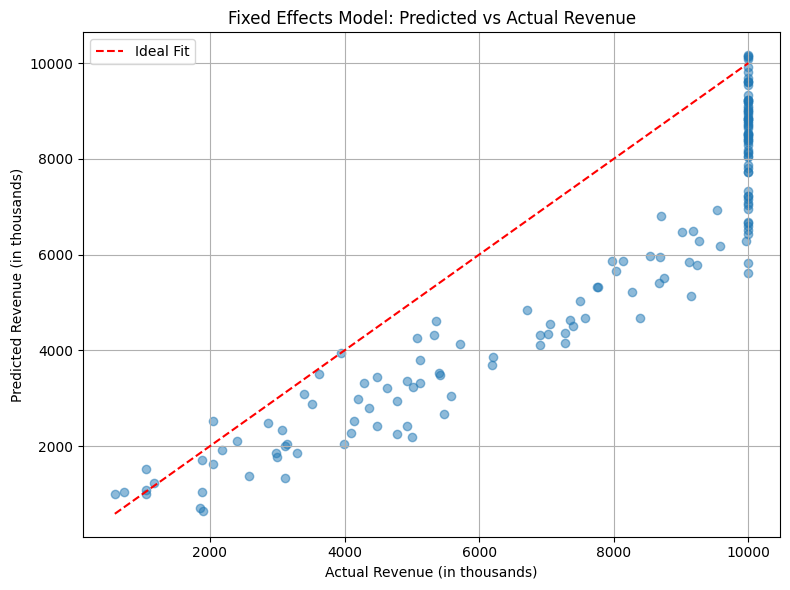

In [11]:
import matplotlib.pyplot as plt

# Plot actual vs predicted revenue
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Revenue (in thousands)')
plt.ylabel('Predicted Revenue (in thousands)')
plt.title('Fixed Effects Model: Predicted vs Actual Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
